# Прогноз проницаемости образцов горной породы по петрофизическим свойствам методами машинного обучения. 
---

<div style="text-align: right"> 
    
    Хакатон Газпром Нефть
    
    18-19/02/21 
    
    Александр Широков
</div> 

---

## 1. Постановка задачи

### 1.1 Признаки 

Необходимо разработать методику для прогноза проницаемости образцов горной породы по их петрофизическим свойствам методами машинного обучения.
Входными признаками являются: 
<ol>
<li>Общая пористость образца ($\Phi$) - это доля объёма порового пространства в общем объёме горного образца.
<li>Профиль пористости образца вдоль оси Z ($\phi_z$) - локальная пористость горного образца замеренная вдоль оси Z, она показывает степень однородности породы по направлению оси Z.
</ol>

### 1.2 Целевая функция:

Абсолютная проницаемость вдоль оси Z ($k_z$)- это величина, характеризующая способность горного образца пропускать жидкость (или газ) при перепаде давления, типичная размерность мД (миллидарси). Чем это значение выше, тем лучше образец пропускает жидкость.

## 2. Data

Загрузим тренировочные и тестовые данные.

### 2.1 Train Data

1. Загрузка **общей пористости образцов** ($\Phi$, porosity):

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_porosity = np.genfromtxt('porosity.csv',
                             invalid_raise=False,
                             comments='#',
                             delimiter=',')
print('Количество образцов в обучающей выборке: ',np.size(train_porosity))

Количество образцов в обучающей выборке:  100


2. Загрузка **профиля пористости образца вдоль оси Z** ($\phi_z$, porosityProfile, был замерен с интервалом 5 мкм):

In [3]:
train_porosityProfile = np.genfromtxt('porosityProfile.csv',
                                  invalid_raise=False,
                                  comments='#',
                                  delimiter=',')
print(f'Размерность признаков профиля пористости {train_porosityProfile.shape}')

Размерность признаков профиля пористости (100, 200)


3. Загрузка абсолютной проницаемости вдоль оси Z ($k_z$, permeabilityZ) - целевой признак $Y$:

In [4]:
train_permeabilityZ = np.genfromtxt('permeabilityZ.csv',
                                    invalid_raise=False,
                                    comments='#',
                                    delimiter=',')

### 2.2 Test Data

1. Загрузка **общей пористости образцов** ($\Phi$, porosity):

In [5]:
test_porosity = np.genfromtxt('test_porosity.csv',
                            invalid_raise=False,
                            comments='#',
                            delimiter=',')
print('Количество образцов в тестовой выборке: ',np.size(test_porosity))

Количество образцов в тестовой выборке:  100


2. Загрузка **профиля пористости образца вдоль оси Z** ($\phi_z$, porosityProfile

In [6]:
test_porosityProfile = np.genfromtxt('test_porosityProfile.csv',
                                     invalid_raise=False,
                                     comments='#',
                                     delimiter=',')
print(f'Размерность признаков профиля пористости {test_porosityProfile.shape}')

Размерность признаков профиля пористости (100, 200)


## 3. Explore Analyse

### 3.1 All Answer in Data

Для начала воспроизведём некоторые действия из `baseline` решения - отобразим зависимость *абсолютной проницаемости* от *общей пористости*:

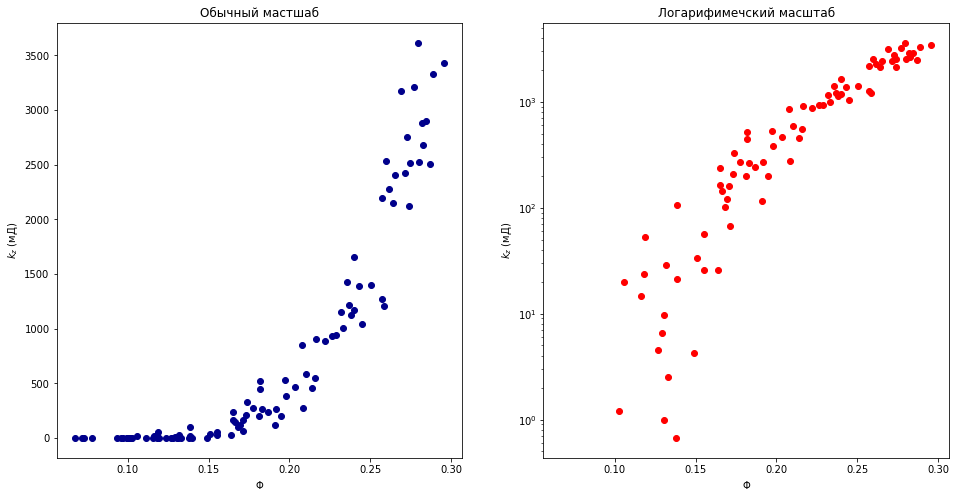

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(train_porosity, train_permeabilityZ, color='darkblue')
ax[0].set_xlabel('$\Phi$')
ax[0].set_title('Обычный мастшаб')
ax[0].set_ylabel('$k_z$ (мД)')
ax[1].semilogy(train_porosity, train_permeabilityZ, 'or')
ax[1].set_xlabel('$\Phi$')
ax[1].set_ylabel('$k_z$ (мД)')
ax[1].set_title('Логарифимечский масштаб')
plt.show()

В `baseline` решении было сделано, логичное предположение, что зависимость проявляется через экспоненциальную функцию. Но, может, зависимость можно уточнить с помощью признаков *профиля пористости образца вдоль оси Z*? Я решил проверить это, и первое сомнение закралось у меня, когда я решил построить корреляционную матрицу признаков:

In [8]:
columns = ['porosity'] + [f'k_{z}' for z in range(1, 201)] + ['Y']
data = pd.DataFrame(data=np.concatenate((train_porosity.reshape(-1, 1), 
                                         train_porosityProfile, 
                                         train_permeabilityZ.reshape(-1, 1)), 
                                        axis=1), 
                    columns=columns)
data.corr()

,porosity,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_9,...,k_192,k_193,k_194,k_195,k_196,k_197,k_198,k_199,k_200,Y
porosity,1.000000,0.854964,0.856588,0.858928,0.864524,0.869726,0.876164,0.884154,0.890864,0.896278,...,0.935272,0.931634,0.927921,0.924229,0.918044,0.909635,0.899475,0.892064,0.888014,0.872960
k_1,0.854964,1.000000,0.999841,0.998645,0.994375,0.985663,0.972690,0.955570,0.935755,0.912288,...,0.806596,0.810321,0.812001,0.814023,0.813938,0.807523,0.800208,0.794044,0.790734,0.714721
k_2,0.856588,0.999841,1.000000,0.999344,0.995887,0.988035,0.975814,0.959306,0.939949,0.916929,...,0.807361,0.810956,0.812581,0.814614,0.814517,0.808119,0.800841,0.794722,0.791421,0.716723
k_3,0.858928,0.998645,0.999344,1.000000,0.998359,0.992431,0.981941,0.966990,0.948805,0.926833,...,0.807629,0.810939,0.812486,0.814530,0.814486,0.808141,0.801019,0.794992,0.791749,0.718428
k_4,0.864524,0.994375,0.995887,0.998359,1.000000,0.997568,0.990259,0.978228,0.962441,0.942602,...,0.810468,0.813553,0.815224,0.817218,0.817109,0.810774,0.803773,0.797834,0.794633,0.723757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
k_197,0.909635,0.807523,0.808119,0.808141,0.810774,0.811840,0.813304,0.813401,0.812240,0.808392,...,0.951935,0.966745,0.980062,0.990687,0.997575,1.000000,0.998105,0.995078,0.993002,0.812183
k_198,0.899475,0.800208,0.800841,0.801019,0.803773,0.804821,0.806370,0.806232,0.804858,0.800673,...,0.936764,0.952902,0.968124,0.981428,0.991826,0.998105,1.000000,0.999217,0.998248,0.799739
k_199,0.892064,0.794044,0.794722,0.794992,0.797834,0.798923,0.800543,0.800315,0.798916,0.794625,...,0.926004,0.942778,0.959133,0.974016,0.986471,0.995078,0.999217,1.000000,0.999781,0.791805
k_200,0.888014,0.790734,0.791421,0.791749,0.794633,0.795719,0.797367,0.797148,0.795764,0.791437,...,0.920197,0.937218,0.954052,0.969703,0.983218,0.993002,0.998248,0.999781,1.000000,0.787216


Показалась удивительной такая мультикоррелярность признаков между собой - конечно, в регресии такие признаки применять нельзя, так как определитель корреляционной матрицы признаков примерно равен нулю (все коэффициенты корреляции близки к 1).

Эта ситуация с матрицей корреляцией натолкнула меня на мысль проверить данные на функциональную зависимость... и я взял среднее по оси `axis=1` данных признаков.

In [9]:
data2 = pd.DataFrame(data=np.concatenate((train_porosity.reshape(-1, 1), 
                                          train_porosityProfile.mean(axis=1).reshape(-1, 1), 
                                          train_permeabilityZ.reshape(-1, 1)), axis=1), 
                     columns=['porosity', 'mean', 'Y'])

In [10]:
np.linalg.norm(train_porosity - train_porosityProfile.mean(axis=1))

1.9279638981753172e-16

In [11]:
data2.corr()

,porosity,mean,Y
porosity,1.00000,1.00000,0.87296
mean,1.00000,1.00000,0.87296
Y,0.87296,0.87296,1.00000


Вау! Оказалось, что общая пористость совпадает со средним значениями по строкам матрицы признаков *профиля пористости образца по оси Z*. Проверим на тестовых данных:

In [12]:
np.linalg.norm(test_porosity - test_porosityProfile.mean(axis=1))

2.0014830212433605e-16

Ура - признаки профиля пористости образца вдоль оси Z можно не рассматривать и предсказывать зависимость по единственному признаку - общей пористости образцов.

### 3.2 Распределение целевой переменной

Для линейной регрессии существует предположение о нормальном распределении целевой переменной, но в данной задаче (как мы увидим чуть позже), распределение не является нормальным. Отобразим гистограмму распределения, используя количество столбцов по методу Стёржеса.

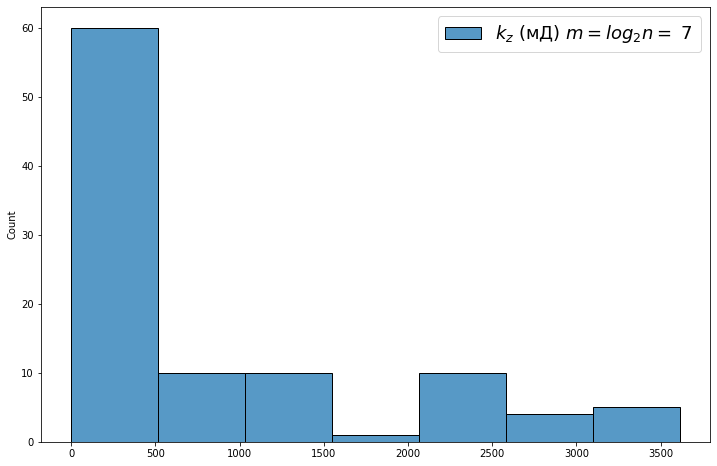

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
sturges_bins = 1 + int(np.log2(train_permeabilityZ.size))
sns.histplot(train_permeabilityZ, 
             ax = ax, 
             bins = sturges_bins, 
             label = fr'$k_z$ (мД) $m = log_2 n = $ {sturges_bins} ')
ax.legend(fontsize = 18)
plt.show()

Задача оценивания плотности является отдельной задачей, которую по=хорошему стоило бы провести, но данное распределение является очень схожим с распределением Пуассона при $\lambda \approx 1$, но так же может быть похоже на [tweedie распределение](https://en.wikipedia.org/wiki/Tweedie_distribution) и `gamma` (при некоторых параметрах). 

Для чего мы оцениваем плотность? Чтобы применить `Generalized Linear Regression`. В модели линейной регрессии делается предположение о том, что компоненты y независимые нормально распределенные случайные величины с постоянной дисперсией. С помощью данного метода мы можем расшиить предположение, чтобы использовать любое распределение из тех, что принадлежат экспоненциальному:

$$p(x,v) = g(x) \cdot e^{xv - d(v)} \in P_v$$

где $E\xi = d'(v)$, а $D\xi = d''(v)$.

Идея состоит в следующем. Необходимо сделать следующее - если обозначить, то $Y_i \sim P_v$, где в качестве параметра $v$ используются скалярное произведение $\langle \overset{\to}{X_i}, \overset{\to}{\beta}\rangle$.

Нам повезло, что по сути нам неважно какое из трех распределений здесь изображено - важно, что функция связи является логистической для всех трёх распределений.

Будем использовать модель `GLM` с предположением о распределении Пуассона, разобьём выборку на `train` и валидацию, подберём параметр регуляризации и предскажем значение по тестовому набору данных - вот, что будет происходить в следующем пункте.

## 4. Train & Validation

Используем реализованную `GLM` модель из `sklearn`:

In [14]:
from sklearn.linear_model import TweedieRegressor

В качестве кросс-валидационного метода будем использовать перекрёстную проверку по фолдам `KFold CV`:

In [15]:
from sklearn.model_selection import KFold

In [16]:
cv = KFold(n_splits=5, shuffle=True)

В качестве оценки качества модели будем использовать следующие функции ошибки:

- названную в `baseline` *среднюю относительная ошибка прогноза по обучающей выборке*, иначе называемую `MAPE` (Mean Absolute Percent Error):

$$\text{MAPE} = \frac{1}{n}\sum\limits_{i=1}^n \frac{\vert y_i - \hat{y}_i \vert }{\vert y_i \vert}$$

где $y_i$ - истинный ответ, а $\hat{y}_i$ - ответ нашего алгоритма на $i$-м объекте.

- `R2` - коэффициент детерминации, доля объяснённой дисперсии:

$$R^2 = \frac{\sum\limits_{i=1}^n \left(\hat{y}_i - \bar{y}\right)^2}{\sum\limits_{i=1}^n \left(y_i - \bar{y}\right)^2}$$

In [17]:
from sklearn.metrics import r2_score

In [18]:
def mean_absolute_percent_error(y_true: np.array, y_pred: np.array):
    return np.mean(np.abs((y_true - y_pred)) / np.abs(y_pred))

В более привычное обозначение перевёдем наш признак и целевую переменную:

In [19]:
X = train_porosity[:, np.newaxis]
y = train_permeabilityZ

Будем перебирать `GridSearch` по следующим параметрам:

-  `power` отвечает за выбор распределения:
    - 1 - `Poisson` распределение (первое предположение)
    - 1.5 - `Tweedy` распределение (второе)
- `alpha` - параметр регуляризации

In [20]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': np.arange(0, 1, 0.01), 
              'power': [1.0, 1.5]}
estimator = TweedieRegressor(link='log')
clf = GridSearchCV(estimator, parameters, cv=cv, scoring='r2')
clf.fit(X, y)
clf.best_estimator_

TweedieRegressor(alpha=0.18, link='log', power=1.0)

Для большей уверенности создадим ансамбль из $10$ регрессоров.

In [36]:
classifiers = []
for i in range(10):
    r2 = []
    mape = []
    cl = TweedieRegressor(power=1.0, alpha=0.09, link='log')
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        cl.fit(X_train, y_train)
        r2.append(r2_score(y_true=y_test, 
                           y_pred=cl.predict(X_test)))

        mape.append(mean_absolute_percent_error(y_true=y_test, 
                           y_pred=cl.predict(X_test)))

        # получим 5 оптимальных классификаторов
    classifiers.append(cl)
    print(f'iteration {i}, R2: {np.mean(r2)}, MAPE: {np.mean(mape)}')

iteration 0, R2: 0.9267835911626046, MAPE: 0.49583457015309784
iteration 1, R2: 0.9381294168617865, MAPE: 0.4952676876830381
iteration 2, R2: 0.9161171717672338, MAPE: 0.5022237463050956
iteration 3, R2: 0.9265910339680051, MAPE: 0.49947411590856045
iteration 4, R2: 0.9254860933852808, MAPE: 0.49953975015224816
iteration 5, R2: 0.9308745991466381, MAPE: 0.49712580408203094
iteration 6, R2: 0.933291071242255, MAPE: 0.49743287740873543
iteration 7, R2: 0.9289346760052236, MAPE: 0.500707591150069
iteration 8, R2: 0.9314364099844802, MAPE: 0.5013647482557603
iteration 9, R2: 0.9276128878028572, MAPE: 0.4970713168348128


Путём проб было выяснено, что коэффициент регуляризации `0.09` уменьшает значение ошибки по метрике `MAPE`, которая использовалась в `baseline` - поэтому использую такое значение `alpha`. Заметим, что ошибку мы улучшили по сравнению с `baseline` решением более чем в $2$ раза.

Модель является достоверной, работает для любой проницаемости, протестирована на кросс-валидации и с помощью перебора параметров найдены лучшие.

Сделаем предсказание на тестовых данных.

## 5. Submission

In [37]:
res = []
for c in classifiers:
    res.append(c.predict(test_porosity[:, np.newaxis]))
dat = pd.DataFrame(np.array(res).T)

In [38]:
submission = dat.mean(axis=1)

In [39]:
np.savetxt('prediction_permeabilityZ.csv', 
           submission, 
           header='абсолютная проницаемость вдоль оси Z (мД)',
           delimiter=",", 
           encoding='utf-8')

## 6. Заключение

В данной работе был проведён предварительный анализ данных, выбран информативный признак, объяснён выбор модели машинного обучения, была продемонстрирована валидность модели на тренировоных данных с помощью метода кросс валидации, была уменьшена более чем в 2 раза ошибка по сравнению с `baseline` решением и с помощью данной модели было загружено предсказание для тестового набора данных.

Спасибо за хакатон!